<a href="https://colab.research.google.com/github/YUFULEO/Reinforcement-learning-and-Inverse-Reinforcement-learning/blob/main/Project3_106181329_306294486_306183290.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Introduction

# Part 2: Reinforcement learning (RL)

## 2.1 Environment

In [ ]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
%matplotlib inline

### Question 1

In [ ]:
def plot_matrix(matrix):
    fig, ax = plt.subplots()
    num_rows = len(matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = matrix[i][j]
            ax.text(j + 0.5, i + 0.5, '{:.1f}'.format(c), va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()
    plt.show()
    plt.close()

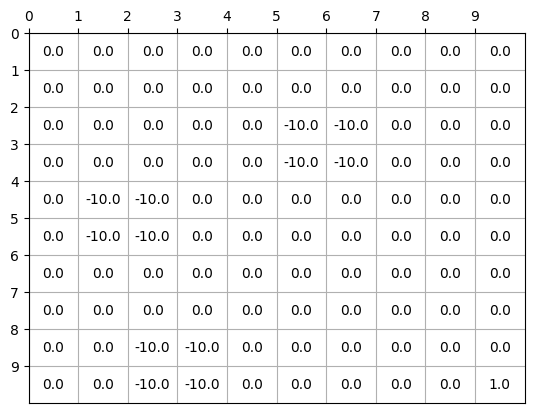

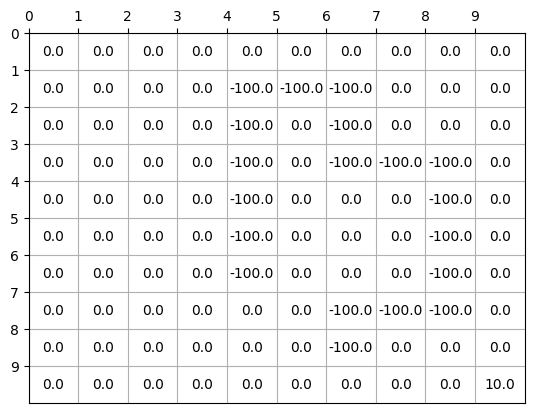

In [ ]:
rf_1 = np.zeros((10, 10))
rf_1[2][5:7] = -10
rf_1[3][5:7] = -10
rf_1[4][1:3] = -10
rf_1[5][1:3] = -10
rf_1[8][2:4] = -10
rf_1[9][2:4] = -10
rf_1[9][9] = 1

plot_matrix(rf_1)

rf_2 = np.zeros((10, 10))
rf_2[1][4:7] = -100
rf_2[2][[4, 6]] = -100
rf_2[3][[4, 6, 7, 8]] = -100
rf_2[4][[4, 8]] = -100
rf_2[5][[4, 8]] = -100
rf_2[6][[4, 8]] = -100
rf_2[7][6:9] = -100
rf_2[8][6] = -100
rf_2[9][9] = 10

plot_matrix(rf_2)

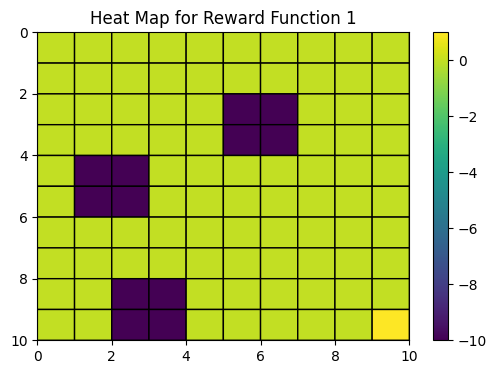

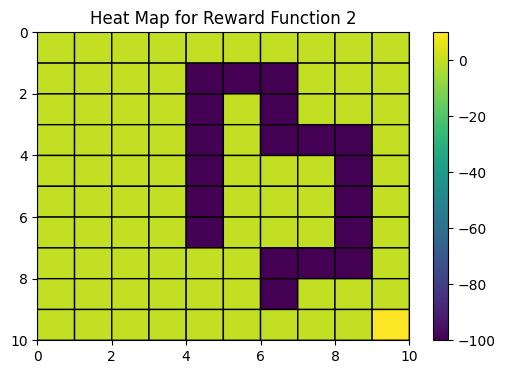

In [ ]:
plt.figure(figsize=(6, 4))
plt.pcolor(rf_1, edgecolors='k', linewidths=1)
plt.colorbar()
plt.title("Heat Map for Reward Function 1")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(6, 4))
plt.pcolor(rf_2, edgecolors='k', linewidths=1)
plt.colorbar()
plt.title("Heat Map for Reward Function 2")
plt.gca().invert_yaxis()
plt.show()

**<font color=blue size=4>Question 1**

**(10 points) For visualization purpose, generate heat maps of Reward function 1 and Reward function 2. For the heat maps, make sure you display the coloring scale. You will have 2 plots for this question**

We generate heat maps of Reward function 1 and Reward function 2 for visualization purpose. We also include the coloring scale for both plots. There are 2 plots in total. You can see the plots above.

# Part 3: Optimal policy learning using RL algorithms

### Question 2

In [ ]:
from itertools import permutations

In [ ]:
## Define the gridworld MDP class

class Gridworld(object):
    """
    Gridworld MDP.
    """

    def __init__(self, grid_size, wind, discount, reward_function):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.discount = discount
        self.reward_function = reward_function

        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])

    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)

    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return int(p[0] + p[1]*self.grid_size)

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given
        action j.

        i: State int.
        j: Action int.
        k: State int.
        -> p(s_k | s_i, a_j)
        """

        xi, yi = self.int_to_point(i)
        xj, yj = self.actions[j]
        xk, yk = self.int_to_point(k)


        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0

        # Is k the intended state to move to?
        if (xi + xj, yi + yj) == (xk, yk):
            return 1 - self.wind + self.wind / 4

        # If these are not the same point, then we can move there by wind.
        if (xi, yi) != (xk, yk):
            return self.wind / 4


        # If these are the same point, we can only move here by either moving
        # off the grid or being blown off the grid. Are we on a corner or not?
        if (xi, yi) in set(permutations([0, 0, self.grid_size - 1, self.grid_size - 1], 2)):
            # Corner.
            # Can move off the edge in two directions.
            # Did we intend to move off the grid?
            if min(xi + xj, yi + yj) < 0 or max(xi + xj, yi + yj) > self.grid_size - 1:
                # we have the regular success chance of staying here
                # plus an extra chance of blowing onto the *other* off-grid square
                return 1 - self.wind / 2
            else:
                # We can blow off the grid in either direction only by wind.
                return self.wind / 2
        else:
            # Not a corner. Is it an edge?
            if min(xi, yi) > 0 and max(xi, yi) < self.grid_size - 1:
                return 0

            else:#it is an edge
                # we Can only move off the edge in one direction.
                # Did we intend to move off the grid?
                if min(xi + xj, yi + yj) < 0 or max(xi + xj, yi + yj) > self.grid_size - 1:
                    #we have the regular success chance of staying here.
                    return 1 - self.wind + self.wind / 4
                else:
                    # We can blow off the grid only by wind.
                    return self.wind / 4

    def reward(self, state_int):
        """
        Reward for being in state state_int.

        state_int: State integer. int.
        -> Reward.
        """

        postive_reward = 10
        negative_reward = -100

        #look at figure 6,7 to retrurn a reward at the given state.

        return None

In [ ]:
## Implementing the algorithm for computing the optimal value function for each state
## The algorithm takes as input the MDP and returns an array of optimal values,
## where i^th value in the array corresponds to the optimal value of the i^th state.

def optimal_value(n_states, n_actions, transition_probabilities, reward,
                  discount, threshold=1e-2):
    """
    Find the optimal value function.

    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probabilities: Function taking (state, action, state) to
        transition probabilities.
    reward: Vector of rewards for each state.
    discount: MDP discount factor. float.
    threshold: Convergence threshold, default 1e-2. float.
    -> Array of values for each state
    """

    v = np.zeros(n_states)

    #write code here
    delta = float('inf')
    steps = 0
    while delta > threshold:
      steps += 1
      if steps % 4 == 0:
        value_matrix = np.zeros((grid_size, grid_size))
        for i in range(gw.n_states):
          value_matrix[int(i%grid_size)][int(i/grid_size)] = round(v[i], 1)
        print(f'At steps {steps}')
        plot_matrix(value_matrix)
      delta = 0
      for i in range(n_states): # ith current state
        val = v[i]
        probabilities = np.zeros(n_actions) # np.array([0, 0, 0, 0])
        for j in range(n_actions): # jth action
          for k in range(n_states): # kth next state
            p = transition_probabilities[i][j][k]
            r = reward.T.flatten()[k]
            probabilities[j] += p * (r + discount * v[k])
        v[i] = max(probabilities)
        delta = max(delta, abs(val - v[i]))

    print(f'Value iteration algorithm converges in {steps} steps.')

    return v

At steps 4


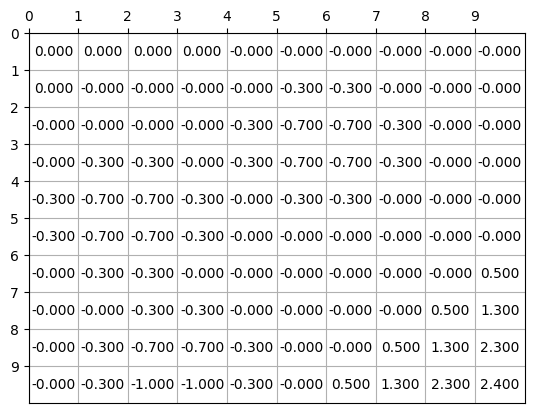

At steps 8


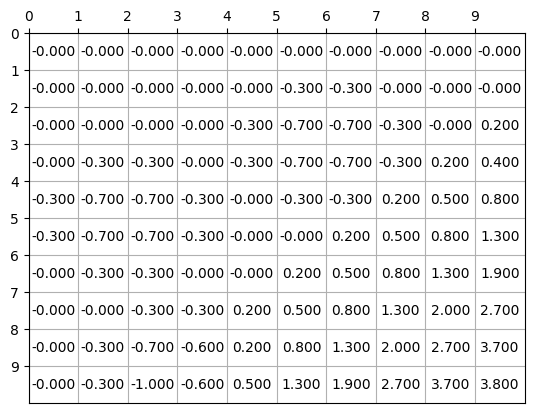

At steps 12


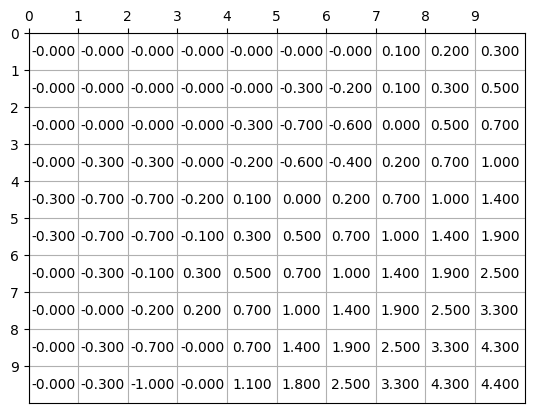

At steps 16


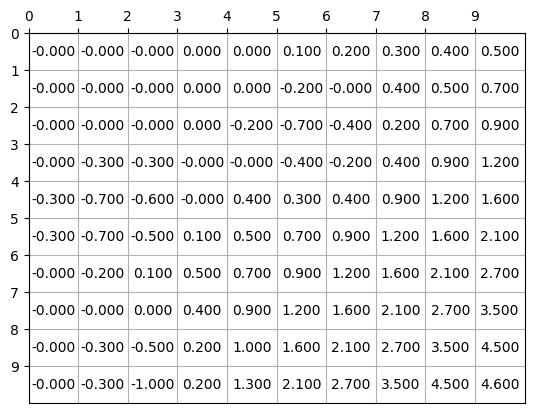

At steps 20


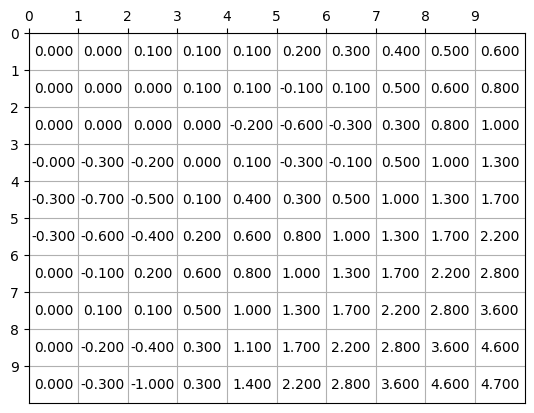

Value iteration algorithm converges in 21 steps.


In [ ]:
grid_size = 10
wind = 0.1
discount = 0.8

gw = Gridworld(grid_size, wind, discount, rf_1)
v = optimal_value(gw.n_states, gw.n_actions, gw.transition_probability, gw.reward_function, gw.discount)

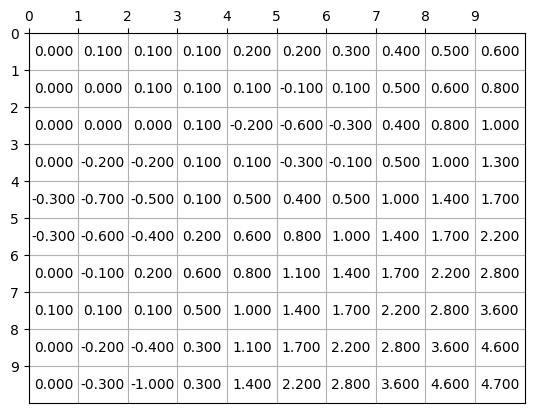

In [ ]:
value_matrix = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    value_matrix[int(i%grid_size)][int(i/grid_size)] = round(v[i], 1)

plot_matrix(value_matrix)

**<font color=blue size=4>Question 2**

**(40 points) Create the environment of the agent using the information provided in section 2. To be specific, create the MDP by setting up the state-space, action set, transition probabilities, discount factor, and reward function. For creating the environment, use the following set of parameters:**

**• Number of states = 100 (state space is a 10 by 10 square grid as displayed in figure 1)**

**• Number of actions = 4 (set of possible actions is displayed in figure 2)**

**• w = 0.1**

**• Discount factor = 0.8**

**• Reward function 1**

**After you have created the environment, then write an optimal state-value function that takes as input the environment of the agent and outputs the optimal value of each state in the grid. For the optimal state-value function, you have to implement the Initialization (lines 2-4) and Estimation (lines 5-13) steps of the Value Iteration algorithm. For the estimation step, use epsilon = 0.01. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal value of that state. In this part of question, you should have 1 plot.**

**Let’s assume that your value iteration algorithm converges in N steps. Plot snapshots of state values in 5 different steps linearly distributed from 1 to N. Report N and your step numbers. What observations do you have from the plots?**

For the question, we create the environment using the following set of parameters: Number of states = 100, Number of actions = 4, w = 0.1, Discount factor = 0.8, and Reward function 1. After created the environment, then we write an optimal state-value function that takes as input the environment of the agent and outputs the optimal value of each state in the grid. We use epsilon = 0.01 in the estimation step. Then we generate a figure for visualization purpose. You can see the plot above.

Also, because value  iteration algorithm converges in N steps, we plot snapshots of state values in 5 different steps linearly distributed from 1 to N. Because value iteration algorithm converges in 21 steps, we plot at step 4, 8, 12, 16, and 20. You can see the plots above. We observe that each image demonstrates progressive improvement in the estimate of state values. This demonstrates how value iteration iteratively refines state value estimations, bringing them closer to the optimal values. Also, there is a distinct trend of growing state values in specific locations of the grid as the number of iterations grows. This implies that some states have higher long-term rewards. The increase is most noticeable in the lower right corner of the grid, which could indicate a goal or high-reward state in that area. At last, by step 20, the differences in state values across snapshots appear to be decreasing, indicating that the value estimates are approaching a stable set of values. The convergence requirement defined by the delta threshold helps to ensure that the process finishes when the values are sufficiently stable.

### Question 3

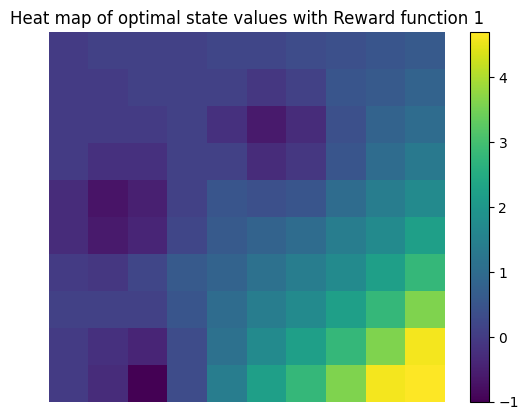

In [ ]:
plt.pcolor(np.flipud(value_matrix))
plt.colorbar()
plt.axis('off')
plt.title('Heat map of optimal state values with Reward function 1')
plt.show()

**<font color=blue size=4>Question 3**

**(5 points) Generate a heat map of the optimal state values across the 2-D grid. For generating the heat map, you can use the same function provided in the hint earlier (see the hint after question 1).**

We generate a heat map of the optimal state values across the 2-D grid. We also include the coloring scale for the plot. You can see the heat map above.

### Question 4

**<font color=blue size=4>Question 4**

**(15 points) Explain the distribution of the optimal state values across the 2-D grid. (Hint: Use the figure generated in question 3 to explain)**

For the distribution of the optimal state values across the 2-D grid, we can observe that the heatmap displays a clear gradient, with values increasing from top left to bottom right. This shows that the agent earns bigger future rewards as it approaches the bottom-right corner of the grid. As the values climb, the colors move from blue to green to yellow, emphasizing the increasing value of states toward the bottom-right corner. Blue regions (negative and low values) indicate penalties, lower rewards, or reduced strategic relevance in that section of the grid. The greatest values are seen in the bottom right corner, with values like 4.7 indicating a potentially big payoff or a series of advantageous transitions leading to that location. This could indicate a target or goal location for the agent. This distribution indicates that an ideal policy would most likely involve maneuvers that drive the agent to the bottom right of the grid, avoiding less valuable states.

### Question 5

In [ ]:
def optimal_action(n_states, n_actions, transition_probabilities, reward,
                  discount, threshold=1e-2):

    v = np.zeros(n_states)
    arrows = np.zeros(n_states)

    #write code here
    delta = float('inf')
    while delta > threshold:
      delta = 0
      for i in range(n_states): # ith current state
        val = v[i]
        probabilities = np.zeros(n_actions)
        for j in range(n_actions): # jth action
          for k in range(n_states): # kth next state
            p = transition_probabilities[i][j][k]
            r = reward.T.flatten()[k]
            probabilities[j] += p * (r + discount * v[k])

        v[i] = max(probabilities)
        delta = max(delta, abs(val - v[i]))

    for i in range(n_states):
      probabilities_i = np.zeros(n_actions)
      for j in range(n_actions):
        for k in range(n_states):
          p = transition_probabilities[i][j][k]
          r = reward.T.flatten()[k]
          probabilities_i[j] += p * (r + discount * v[k])
      arrows[i] = np.argmax(probabilities_i)

    return arrows

In [ ]:
grid_size = 10
wind = 0.1
discount = 0.8

gw = Gridworld(grid_size, wind, discount, rf_1)
arrows = optimal_action(gw.n_states, gw.n_actions, gw.transition_probability, gw.reward_function, gw.discount)

In [ ]:
arrow_symbol = ['\u2193', '\u2192', '\u2191', '\u2190']
arrows = np.array([arrow_symbol[int(a)] for a in arrows])

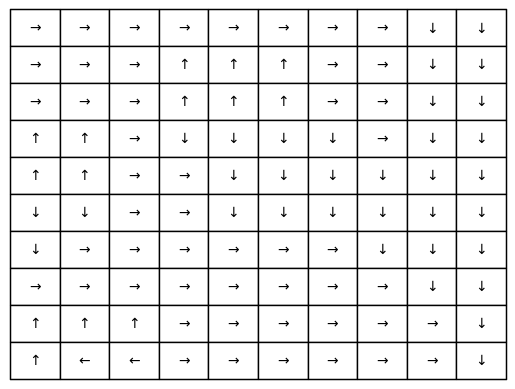

In [ ]:
arrow_table = arrows.reshape(10, 10).transpose()
plt.figure()
tb = plt.table(cellText=arrow_table, loc=(0,0), cellLoc='center')
tc = tb.properties()['children']
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

**<font color=blue size=4>Question 5**

**(20 points) Implement the computation step of the value iteration algorithm 8 (lines 14-17) to compute the optimal policy of the agent navigating the 2-D state-space. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The optimal actions should be displayed using arrows. Does the optimal policy of the agent match your intuition? Please provide a brief explanation. Is it possible for the agent to compute the optimal action to take at each state by observing the optimal values of it’s neighboring states? In this question, you should have 1 plot.**

We implement the computation step of the value iteration algorithm 8 to compute the optimal policy of the agent navigating the 2-D state-space. And we generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. And the optimal actions are displayed using arrows. There is 1 plot in total. You can see the plot above. The optimal policy of the agent match our intuition. Because you can see that the most of upper states in the grid tend to take action to go down and right. The most of left states in the grid tend to take action to go right. Because the bottom-right corner has the highest optimal value. This trend is typically indicative of a gradient ascent approach where the agent consistently moves toward higher-value states. In summary, The alignment of arrows suggesting rightward and downward movements in most of the grid aligns with the expected strategy to maximize value, assuming higher values are located towards the bottom-right. Therefore, it is possible for the agent to compute the optimal action to take at each state by observing the optimal values of it’s neighboring states.

### Question 6

In [ ]:
grid_size = 10
wind = 0.1
discount = 0.8

gw = Gridworld(grid_size, wind, discount, rf_2)
v = optimal_value(gw.n_states, gw.n_actions, gw.transition_probability, gw.reward_function, gw.discount)

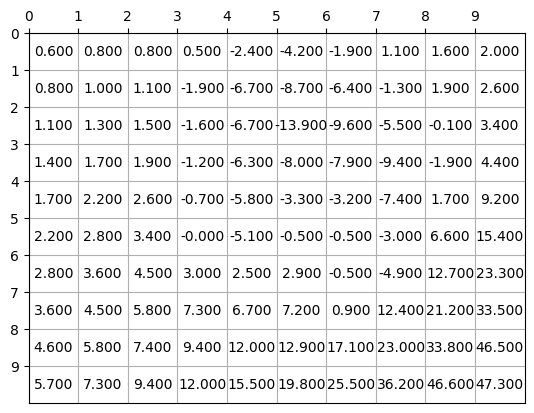

In [ ]:
value_matrix = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    value_matrix[int(i%grid_size)][int(i/grid_size)] = round(v[i], 1)

plot_matrix(value_matrix)

**<font color=blue size=4>Question 6**

**(10 points) Modify the environment of the agent by replacing Reward function 1 with Reward function 2. Use the optimal state-value function implemented in question 2 to compute the optimal value of each state in the grid. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal value of that state. In this question, you should have 1 plot.**

We modify the environment of the agent by replacing Reward function 1 with Reward function 2. We use the optimal state-value function implemented in question 2 to compute the optimal value of each state in the grid. Then we generate a figure similar to that of figure 1 but with the number of state replaced by the optimal value of that state for visualization purpose. You can see the plot above. There is 1 plot in total.

### Question 7

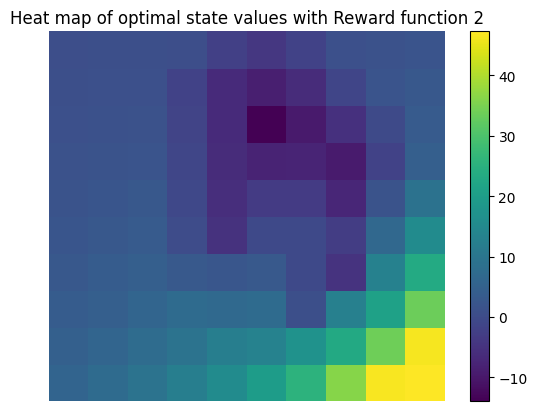

In [ ]:
plt.pcolor(np.flipud(value_matrix))
plt.colorbar()
plt.axis('off')
plt.title('Heat map of optimal state values with Reward function 2')
plt.show()

**<font color=blue size=4>Question 7**

**(20 points) Generate a heat map of the optimal state values (found in question 6) across the 2-D grid. For generating the heat map, you can use the same function provided in the hint earlier. Explain the distribution of the optimal state values across the 2-D grid. (Hint: Use the figure generated in this question to explain)**

We generate a heat map of the optimal state values (found in question 6) across the 2-D grid. You can see the heat map above. We can observe that unlike the heat map generated in question 3, this heatmap shows considerably varied state values throughout the grid—in other words, values are different between very large negatives to those above 40. This would hence suggest that the given environment is more complex and may be strategically challenging, as the structure of rewards has high influence over which strategy will be the best to adopt. The greatest values are seen in the lower right quadrant, particularly close to the grid's edge. These increase significantly, with the highest value reaching more than 46. This shows that the reward function strongly favors these states, which could reflect goal areas or highly desirable places in the environment. The movement of negative numbers in the center to positive values as one proceeds outside and downward indicates a risk gradient. It can be assumed that the core region of the grid contains some type of risk or expense that the agent must navigate or avoid. Optimal pathways will typically avoid these places unless direct traversal is required due to state transitions imposed by the environment.

### Question 8

In [ ]:
grid_size = 10
wind = 0.1
discount = 0.8

gw = Gridworld(grid_size, wind, discount, rf_2)
arrows = optimal_action(gw.n_states, gw.n_actions, gw.transition_probability, gw.reward_function, gw.discount)

In [ ]:
arrow_symbol = ['\u2193', '\u2192', '\u2191', '\u2190']
arrows = np.array([arrow_symbol[int(a)] for a in arrows])

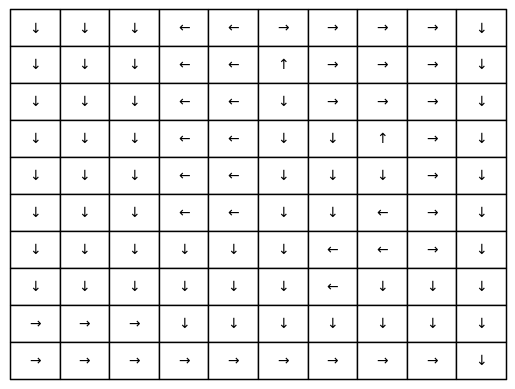

In [ ]:
arrow_table = arrows.reshape(10, 10).transpose()
plt.figure()
tb = plt.table(cellText=arrow_table, loc=(0,0), cellLoc='center')
tc = tb.properties()['children']
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

**<font color=blue size=4>Question 8**

**(20 points) Implement the computation step of the value iteration algorithm (lines 14-17) to compute the optimal policy of the agent navigating the 2-D state-space. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The optimal actions should be displayed using arrows. Does the optimal policy of the agent match your intuition? Please provide a brief explanation. In this question, you should have 1 plot.**

We implement the computation step of the value iteration algorithm (lines 14-17) to compute the optimal policy of the agent navigating the 2-D state-space. Then we generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state for visualization purpose. We use arrows to display the optimal actions. You can see the plot above. There is 1 plot in total. The optimal policy of the agent match our intuition. You can see that the most of upper states still tend to take action to right and down. The most of left states tend to take action to the right. Because the bottom-right corner has the highest optimal value. However, on the right side of the grid, there are some states not follow the trend. That's because there are some negative values in the states. And these states will tend to move to the neighbors which have the higher value. That's why some states will go left and go up. Therefore, the optimal policy of the agent still match our intuition.

### Question 9

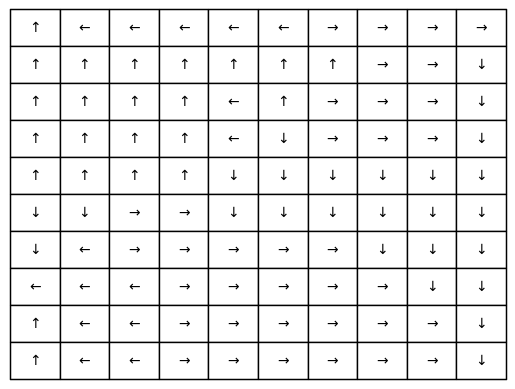

In [ ]:
# With Reward Function 1
grid_size = 10
wind = 0.6
discount = 0.8

gw = Gridworld(grid_size, wind, discount, rf_1)
arrows = optimal_action(gw.n_states, gw.n_actions, gw.transition_probability, gw.reward_function, gw.discount)
arrow_symbol = ['\u2193', '\u2192', '\u2191', '\u2190']
arrows = np.array([arrow_symbol[int(a)] for a in arrows])
arrow_table = arrows.reshape(10, 10).transpose()
plt.figure()
tb = plt.table(cellText=arrow_table, loc=(0,0), cellLoc='center')
tc = tb.properties()['children']
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

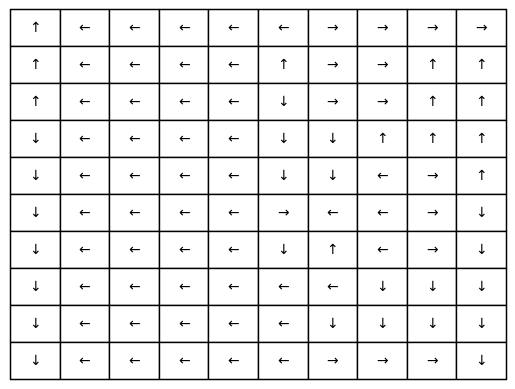

In [ ]:
# With Reward Function 2
grid_size = 10
wind = 0.6
discount = 0.8

gw = Gridworld(grid_size, wind, discount, rf_2)
arrows = optimal_action(gw.n_states, gw.n_actions, gw.transition_probability, gw.reward_function, gw.discount)
arrow_symbol = ['\u2193', '\u2192', '\u2191', '\u2190']
arrows = np.array([arrow_symbol[int(a)] for a in arrows])
arrow_table = arrows.reshape(10, 10).transpose()
plt.figure()
tb = plt.table(cellText=arrow_table, loc=(0,0), cellLoc='center')
tc = tb.properties()['children']
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

**<font color=blue size=4>Question 9**

**(20 points) Change the hyper parameter w to 0.6 and find the optimal policy map similar to previous question for reward functions. Explain the differences you observe. What do you think about value of new w compared to previous value? Choose the w that you think give rise to better optimal policy and use that w for the next stages of the project.**

We change the hyper parameter w to 0.6 and find the optimal policy map similar to previous question for reward functions. There are 2 plots in total. You can see the plots above. We observe that when w=0.1, almost all arrows point more consistently to the lower right corner for both reward function 1 and reward function 2, even though reward function 2 contains some negative values. This is because the optimal value in the lower right corner is the largest. But when w=0.6, the overall trend of the arrows does not point to the lower right, for example there are many arrows pointing up and to the left. This is because when the value of w is higher, there is a greater chance that a state will randomly point to another state, so it is better when w=0.1. Therefore, we chose w = 0.1 which give rise to better optimal policy.

# Part 4:  Inverse Reinforcement learning (IRL)

## IRL algorithm

### Question 10

**<font color=blue size=4>Question 10**

**(10 points) Express $c$, $x$, $D$, $b$ in terms of $R$, $P_a$, $Pa1$, $t_i$, $u$, $λ$ and $Rmax$**

For $c$:

$c = \begin{bmatrix}
1_{|S| \times 1} \\
-\lambda_{|S| \times 1} \\
0_{|S| \times 1}
\end{bmatrix}$

For $x$:

$x = \begin{bmatrix}
t \\
u \\
R
\end{bmatrix}$

For $D$:

$D = \begin{bmatrix}
I_{|S| \times |S|} & 0 & (P_{a1} - P_a)(I - \gamma P_{a1})^{-1} \\
0 & 0 & (P_{a1} - P_a)(I - \gamma P_{a1})^{-1} \\
0 & -I_{|S| \times |S|} & I_{|S| \times |S|} \\
0 & -I_{|S| \times |S|} & -I_{|S| \times |S|} \\
0 & 0 & I_{|S| \times |S|} \\
0 & 0 & -I_{|S| \times |S|}
\end{bmatrix}$

For $b$:

$b = \begin{bmatrix}
0_{|S| \times 1} \\
0_{|S| \times 1} \\
0_{|S| \times 1} \\
0_{|S| \times 1} \\
(R_{\text{max}})_{|S| \times 1} \\
(R_{\text{max}})_{|S| \times 1}
\end{bmatrix}$

## Performance measure

In [ ]:
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

In [ ]:
## IRL algorithm
## LP formulation
def T(a, s):
    return np.matmul(a, s)

def get_c_D_b(n_states, n_actions, transition_probability, policy, Rmax, discount, l1):
    A = set(range(n_actions))
    ones_vec = np.ones(n_states)
    neg_lbd_vec = np.ones(n_states) * (-l1)
    zeros_vec = np.zeros(n_states)
    I_mat = np.eye(n_states)
    zeros_mat = np.zeros((n_states, n_states))
    Rmax_vec = np.ones(n_states) * (Rmax)

    #contruct c [1, -l1, 0]
    c = np.vstack((ones_vec, neg_lbd_vec, zeros_vec))
    #construct D col 1, 2, 3
    col_3_mat = []

    for i in range(n_states):
      a1 = int(policy[i])
      for a in A:
        a = int(a)
        if a1 == a:
          continue
        pa1 = transition_probability[a1]
        pa1_i = pa1[i]
        pa_i = transition_probability[a][i]
        pa1_minus_pa = pa1_i - pa_i
        I_minus_l1pa1_inv = np.linalg.inv(I_mat - discount * pa1)
        a_constraint = T(pa1_minus_pa, I_minus_l1pa1_inv)
        col_3_mat.append(a_constraint)

    col_3_mat = np.vstack(col_3_mat) # 300 x 100
    col_3 = np.vstack((-col_3_mat, -col_3_mat, -I_mat, I_mat, I_mat, -I_mat))
    I_mat_repeat = np.array([(I_mat[i], I_mat[i], I_mat[i]) for i in range(n_states)]).reshape(300, 100)
    #col_1 = np.vstack((I_mat, I_mat, I_mat, zeros_mat, zeros_mat, zeros_mat,
    #                   zeros_mat, zeros_mat, zeros_mat, zeros_mat))
    col_1 = np.vstack((I_mat_repeat, zeros_mat, zeros_mat, zeros_mat,
                       zeros_mat, zeros_mat, zeros_mat, zeros_mat))
    col_2 = np.vstack((zeros_mat, zeros_mat, zeros_mat, zeros_mat, zeros_mat,
                       zeros_mat, -I_mat, -I_mat, zeros_mat, zeros_mat))
    D = np.hstack((col_1, col_2, col_3))


    b = np.vstack((zeros_vec, zeros_vec, zeros_vec, zeros_vec, zeros_vec,
                   zeros_vec, zeros_vec, zeros_vec, Rmax_vec, Rmax_vec))



    return c, D, b


def irl(n_states, n_actions, transition_probability, policy, discount, Rmax, l1):
    """
    Find a reward function with inverse RL as described in Ng & Russell, 2000.
    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probability: NumPy array mapping (state_i, action, state_k) to
        the probability of transitioning from state_i to state_k under action.
        Shape (N, A, N).
    policy: Vector mapping state ints to action ints. Shape (N,).
    discount: Discount factor. float.
    Rmax: Maximum reward. float.
    l1: l1 regularisation. float.
    -> Reward vector
    """

    A = set(range(n_actions))  # Set of actions to help manage reordering
                               # actions.
    # The transition policy convention is different here to the rest of the code
    # for legacy reasons; here, we reorder axes to fix this. We expect the
    # new probabilities to be of the shape (A, N, N).
    transition_probability = np.transpose(transition_probability, (1, 0, 2))

    def T(a, s):
        """
        Shorthand for a dot product used a lot in the LP formulation.
        """

        return np.matmul(a, s)

    # This entire function just computes the block matrices used for the LP
    # formulation of IRL.

    # Minimise c . x.

    ##WRITE CODE HERE
    c, D, b = get_c_D_b(n_states, n_actions, transition_probability, policy, Rmax, discount, l1)
    sol = solvers.lp(matrix(c.flatten()), matrix(D), matrix(b.flatten()))
    solution = sol['x'][-100:]


    return np.array(solution)

In [ ]:
def accuracy(exp_pol, ag_pol):
    num_states = len(exp_pol)
    count = 0.0

    for i in range(num_states):
        if exp_pol[i] == ag_pol[i]:
            count += 1

    return np.divide(count, num_states)


def iter_acc(grid_obj, op_pol):
    n_states = grid_obj.n_states
    n_actions = grid_obj.n_actions
    tr_prob = grid_obj.transition_probability
    disc = grid_obj.discount
    Rmax = 100
    accuracy_array = []


    lam_range = np.linspace(0,5,500)


    for lam in lam_range:
        ag_rf = irl(n_states, n_actions, tr_prob, op_pol, disc, Rmax, lam)
        ag_policy = optimal_action(n_states, n_actions, tr_prob, ag_rf, disc)
        acc = accuracy(op_pol, ag_policy)
        accuracy_array.append(acc)

    best_pol_ind = np.argmax(accuracy_array)
    best_lambda = lam_range[best_pol_ind]

    plt.plot(lam_range, accuracy_array)
    plt.title('Accuracy vs. Lambda')

    return np.amax(accuracy_array), best_lambda, accuracy_array


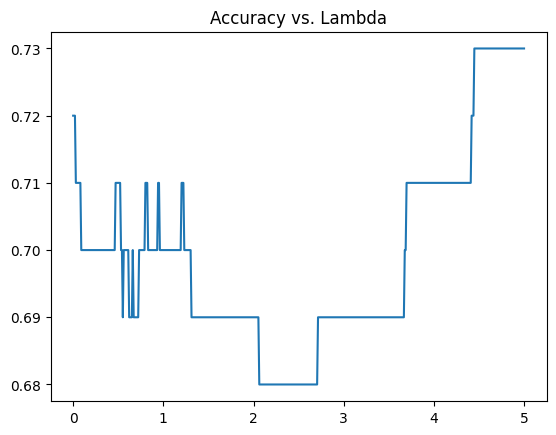

In [ ]:
grid_size = 10
wind = 0.1
discount = 0.8

gw = Gridworld(grid_size, wind, discount, rf_1)
optimal_policy = optimal_action(gw.n_states, gw.n_actions, gw.transition_probability, gw.reward_function, gw.discount)
max_acc, best_lambda, accuracy_array = iter_acc(gw, optimal_policy)

### Question 11

**<font color=blue size=4>Question 11**

**(30 points) Sweep λ from 0 to 5 to get 500 evenly spaced values for λ. For each value of λ compute OA(s) by following the process described above. For this problem, use the optimal policy of the agent found in question 5 to fill in the OE(s) values. Then use equation 3 to compute the accuracy of the IRL algorithm for this value of λ. You need to repeat the above process for all 500 values of λ to get 500 data points. Plot λ (x-axis) against Accuracy (y-axis). In this question, you should have 1 plot.**

We sweep λ from 0 to 5 to get 500 evenly spaced values for λ. For each value of λ, we compute OA(s) by following the process described in the document. Then we use the optimal policy of the agent found in question 5 to fill in the OE(s) values. Then we use equation 3 to compute the accuracy of the IRL algorithm for this value of λ. We repeat the above process for all 500 values of λ to get 500 data points. At last, we plot λ (x-axis) against Accuracy (y-axis). You can see the plot above. We observed that when Lambda equals 0, the accuracy reaches about 0.72. As Lambda gradually increases, accuracy sometimes increases, but other times it decreases. When Lambda is between 2 and 3, accuracy reaches its lowest value, around 0.68. As Lambda approaches 5, accuracy reaches its highest value, 0.73. This trend is in line with our expectations.

### Question 12

In [ ]:
lambda_1_max = best_lambda
print(lambda_1_max)

4.448897795591182


**<font color=blue size=4>Question 12**

**(5 points) Use the plot in question 11 to compute the value of λ for which accuracy is maximum. For future reference we will denote this value as λ(1)max. Please report λ(1)max**

We use the plot in question 11 to compute the value of λ for which accuracy is maximum. We also denote this value as λ(1)max for future reference. λ(1)max is equal to 4.448897795591182. You can see the results above.

### Question 13

In [ ]:
grid_size = 10
wind = 0.1
discount = 0.8

gw = Gridworld(grid_size, wind, discount, rf_1)
optimal_policy = optimal_action(gw.n_states, gw.n_actions, gw.transition_probability, gw.reward_function, gw.discount)
extracted_reward = irl(gw.n_states, gw.n_actions, gw.transition_probability, optimal_policy, discount, 100, lambda_1_max)

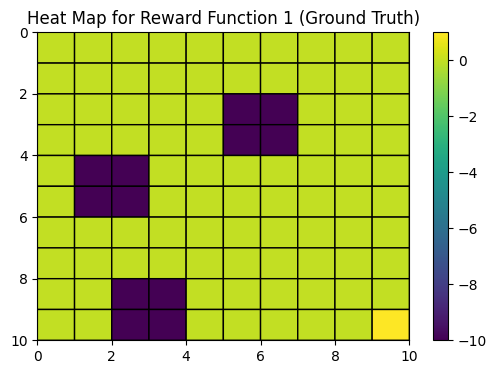

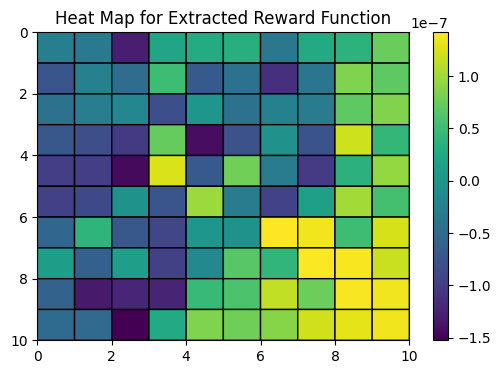

In [ ]:
plt.figure(figsize=(6, 4))
plt.pcolor(rf_1, edgecolors='k', linewidths=1)
plt.colorbar()
plt.title("Heat Map for Reward Function 1 (Ground Truth)")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(6, 4))
plt.pcolor(extracted_reward.reshape(10, 10).T, edgecolors='k', linewidths=1)
plt.colorbar()
plt.title("Heat Map for Extracted Reward Function")
plt.gca().invert_yaxis()
plt.show()

**<font color=blue size=4>Question 13**

**For λ(1)max, generate heat maps of the ground truth reward and the extracted reward. Please note that the ground truth reward is the Reward function 1 and the extracted reward is computed by solving the linear program given by equation 2 with the λ parameter set to λ(1)max. In this question, you should have 2 plots.**

For λ(1)max, we generate heat maps of the ground truth reward and the extracted reward. The ground truth reward is the Reward function 1 and the extracted reward is computed by solving the linear program given by equation 2 with the λ parameter set to λ(1)max. There are 2 plots in total. You can see the plots above. The extracted function often follows the ground truth pattern, with high and low reward zones located in about the same places. This shows that the extraction procedure is somewhat accurate. Also, the extracted function has a decreased scale factor (1e−7), indicating that the magnitude of rewards is greatly reduced. The values also change from dark purples and blues to lighter colors, indicating a different scaling or normalization process.

### Question 14

In [ ]:
## Implementing the algorithm for computing the optimal value function for each state
## The algorithm takes as input the MDP and returns an array of optimal values,
## where i^th value in the array corresponds to the optimal value of the i^th state.

def optimal_value(n_states, n_actions, transition_probabilities, reward,
                  discount, threshold=1e-2):
    v = np.zeros(n_states)
    delta = float('inf')
    while delta > threshold:
      delta = 0
      for i in range(n_states): # ith current state
        val = v[i]
        probabilities = np.zeros(n_actions) # np.array([0, 0, 0, 0])
        for j in range(n_actions): # jth action
          for k in range(n_states): # kth next state
            p = transition_probabilities[i][j][k]
            r = reward.T.flatten()[k]
            probabilities[j] += p * (r + discount * v[k])
        v[i] = max(probabilities)
        delta = max(delta, abs(val - v[i]))

    return v

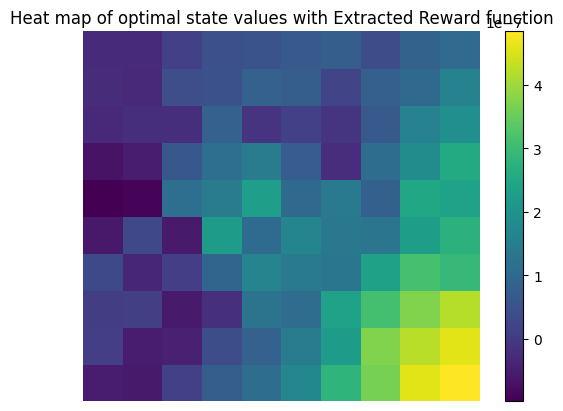

In [ ]:
v = optimal_value(gw.n_states, gw.n_actions, gw.transition_probability, extracted_reward, discount)
value_matrix = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    value_matrix[int(i%grid_size)][int(i/grid_size)] = v[i]

plt.pcolor(np.flipud(value_matrix))
plt.colorbar()
plt.axis('off')
plt.title('Heat map of optimal state values with Extracted Reward function')
plt.show()

**<font color=blue size=4>Question 14**

**(10 points) Use the extracted reward function computed in question 13, to compute the optimal values of the states in the 2-D grid. For computing the optimal values you need to use the optimal state-value function that you wrote in question 2. For visualization purpose, generate a heat map of the optimal state values across the 2-D grid (similar to the figure generated in question 3). In this question, you should have 1 plot.**

We use the extracted reward function computed in question 13 to compute the optimal values of the states in the 2-D grid. We also use the optimal state-value function that we wrote in question 2. Then we generate a heat map of the optimal state values across the 2-D grid for visualization purpose. There is 1 plot in total. You can see the plot above.

### Question 15

**<font color=blue size=4>Question 15**

**Compare the heat maps of Question 3 and Question 14 and provide a brief explanation on their similarities and differences.**

Through compare these two heat maps, there are some similarities and differences. For similarities, both heat maps show a similar gradient, with values increasing from one side of the map to the other. This implies that the primary trend in state value changes across the environment is captured in both the ground truth and extracted models. Also, both maps exhibit greater values (yellow to light green regions) on the same side of the map, showing that both models capture the state space's highest values similarly. At last, both heat maps appear to have an approximately diagonal gradient of increasing values from top left to bottom right. This consistency shows that the extracted model accurately acquired the general directionality of value distribution from the ground truth.

For differences, the first heat map (ground truth) distinguishes more clearly between the greatest and lowest values. The second map (extracted function) is more muted, with less contrast between high and low values. This could point to a variation in scale or sensitivity between the two models. Also, while both maps show high values in similar areas, the specific locations of the greatest values (yellow zones) differ slightly. The ground truth has a more concentrated area of high values, whereas the extracted function has a larger but less intense high-value area. At last, the second heat map appears to have more variance in intermediate values, with patches of different colors dispersed rather than forming a steady gradient. This could imply that the model deriving the reward function contains more noise or is less stable in estimating intermediate values.

### Question 16

In [ ]:
def optimal_action(n_states, n_actions, transition_probabilities, reward,
                  discount, threshold=1e-2):

    v = np.zeros(n_states)
    arrows = np.zeros(n_states)

    #write code here
    delta = float('inf')
    while delta > threshold:
      delta = 0
      for i in range(n_states): # ith current state
        val = v[i]
        probabilities = np.zeros(n_actions)
        for j in range(n_actions): # jth action
          for k in range(n_states): # kth next state
            p = transition_probabilities[i][j][k]
            r = reward.T.flatten()[k]
            probabilities[j] += p * (r + discount * v[k])

        v[i] = max(probabilities)
        delta = max(delta, abs(val - v[i]))

    for i in range(n_states):
      probabilities_i = np.zeros(n_actions)
      for j in range(n_actions):
        for k in range(n_states):
          p = transition_probabilities[i][j][k]
          r = reward.T.flatten()[k]
          probabilities_i[j] += p * (r + discount * v[k])
      arrows[i] = np.argmax(probabilities_i)

    return arrows

In [ ]:
grid_size = 10
wind = 0.1
discount = 0.8

gw = Gridworld(grid_size, wind, discount, extracted_reward)
arrows = optimal_action(gw.n_states, gw.n_actions, gw.transition_probability, gw.reward_function, gw.discount)

In [ ]:
arrow_symbol = ['\u2193', '\u2192', '\u2191', '\u2190']
arrows = np.array([arrow_symbol[int(a)] for a in arrows])

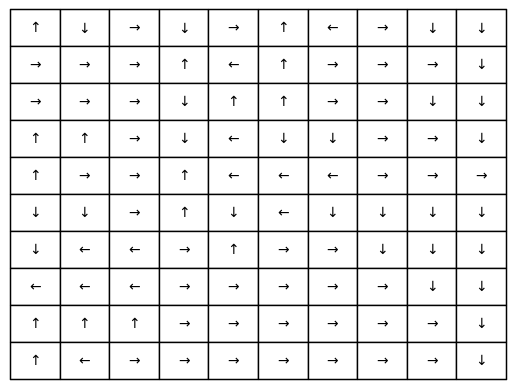

In [ ]:
arrow_table = arrows.reshape(10, 10).transpose()
plt.figure()
tb = plt.table(cellText=arrow_table, loc=(0,0), cellLoc='center')
tc = tb.properties()['children']
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

**<font color=blue size=4>Question 16**

**(10 points) Use the extracted reward function found in question 13 to compute the optimal policy of the agent. For computing the optimal policy of the agent you need to use the function that you wrote in question 5. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The actions should be displayed using arrows. In this question, you should have 1 plot.**

We use the extracted reward function found in question 13 to compute the optimal policy of the agent. We use the function that we wrote in question 5 to compute the optimal policy of the agent. We generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state for visualization purpose. We displayed the actions using arrows. There is 1 plot in total. You can see the plot above.

### Question 17

**<font color=blue size=4>Question 17**

**(10 points) Compare the figures of Question 5 and Question 16 and provide a brief explanation on their similarities and differences.**

Through compare these two heat maps, there are some similarities and differences. For similarities, both figures are grid-based, with arrows suggesting the ideal action at each state. The grid format indicates that both situations are placed in a spatially structured world. Also, in both grids, certain directions are prominently preferred in various regions. For example, there are regions in both grids where downward (↓) or rightward (→) movements are predominant, indicating that the optimal strategy might involve moving toward certain goals or away from certain hazards located in specific parts of the grid. For example, the optimal state at the bottom right corner.

For differences, the first grid exhibits more uniform directionality in larger contiguous portions of the grid. Large parts, for example, point continuously to the right or downward. In contrast, the second grid shows more variance within smaller clusters, implying a potentially more sophisticated or differently organized underlying reward function or a distinct set of environmental obstacles/constraints. Also, the policy depicted in the second grid appears to be more sophisticated, with frequent shifts in direction from one cell to its neighbors.

### Question 18

In [ ]:
# sweep over different values of lambda
from tqdm import tqdm

grid_size = 10
wind = 0.1
discount = 0.8

gw = Gridworld(grid_size, wind, discount, rf_2)

optimal_policy = optimal_action(gw.n_states, gw.n_actions, gw.transition_probability, gw.reward_function, gw.discount)

number_of_lambdas = 500
lambda_range = np.linspace(0, 5, number_of_lambdas)

accuracy_list = []

for l in tqdm(lambda_range):
    reward = irl(gw.n_states, gw.n_actions, gw.transition_probability, optimal_policy, gw.discount, 100, l)
    policy = optimal_action(gw.n_states, gw.n_actions, gw.transition_probability, reward, gw.discount)
    accuracy_list.append(accuracy(optimal_policy, policy))

100%|██████████| 500/500 [05:24<00:00,  1.54it/s]


Text(0.5, 1.0, 'Accuracy vs Lambda')

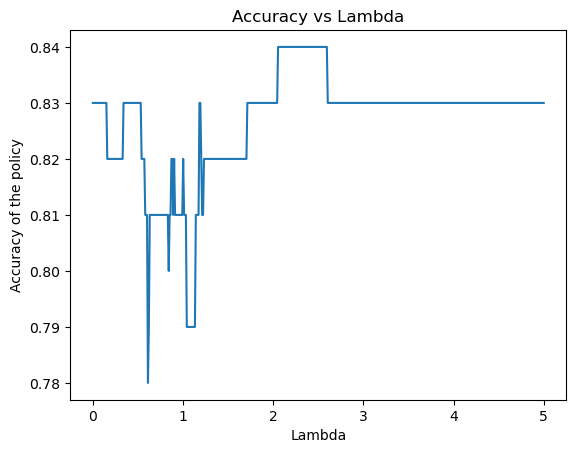

In [ ]:
# plot the accuracy vs lambda
plt.plot(lambda_range, accuracy_list)
plt.xlabel('Lambda')
plt.ylabel('Accuracy of the policy')
plt.title('Accuracy vs Lambda')

**<font color=blue size=4>Question 18**

**(30 points) Sweep λ from 0 to 5 to get 500 evenly spaced values for λ. For each value of λ compute OA(s) by following the process described above. For this problem, use the optimal policy of the agent found in question 8 to fill in the OE(s) values. Then use equation 3 to compute the accuracy of the IRL algorithm for this value of λ. You need to repeat the above process for all 500 values of λ to get 500 data points. Plot λ (x-axis) against Accuracy (y-axis). In this question, you should have 1 plot.**

We repeated the above process for 500 times. The graph is displayed above, we can see that the accuracy is highest when λ is around 2. The accuracy is lowest when λ is around 0.5.

### Question 19

In [ ]:
# find the best lambda
best_lambda = lambda_range[np.argmax(accuracy_list)]
print(f'Best lambda: {best_lambda}')

# get the best accuracy
best_accuracy = np.max(accuracy_list)
print(f'Best accuracy: {best_accuracy}')

Best lambda: 2.0541082164328657
Best accuracy: 0.84


**<font color=blue size=4>Question 19**

**(5 points) Use the plot in question 18 to compute the value of λ for which accuracy is maximum. For future reference we will denote this value as λ(2)max. Please report λ(2)max**

You can see the results above.

The best lambda is 2.0541082164328657 with an accuracy of 0.84.

### Question 20

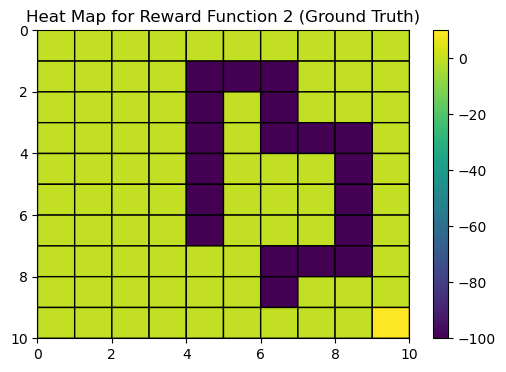

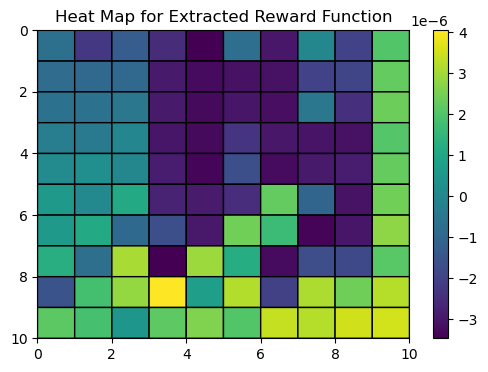

In [ ]:
# extract the reward using the best lambda

reward = irl(gw.n_states, gw.n_actions, gw.transition_probability, optimal_policy, gw.discount, 100, best_lambda)

plt.figure(figsize=(6, 4))
plt.pcolor(rf_2, edgecolors='k', linewidths=1)
plt.colorbar()
plt.title("Heat Map for Reward Function 2 (Ground Truth)")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(6, 4))
plt.pcolor(reward.reshape(10, 10).T, edgecolors='k', linewidths=1)
plt.colorbar()
plt.title("Heat Map for Extracted Reward Function")
plt.gca().invert_yaxis()
plt.show()

**<font color=blue size=4>Question 20**

**(15 points) For λ(2)max, generate heat maps of the ground truth reward and the extracted reward. Please note that the ground truth reward is the Reward function 2 and the extracted reward is computed by solving the linear program given by equation 2 with the λ parameter set to λ(2)max. In this question, you should have 2 plots.**

We generate heat maps of the ground truth reward and the extracted reward for λ(2)max. The ground truth reward is the Reward function 2 and the extracted reward is computed by solving the linear program given by equation 2 with the λ parameter set to λ(2)max. There are 2 plots in total. You can see the plots above.

By looking the heat maps, we can see that the extracted reward function closely resembles the ground truth reward function. The extracted reward function captures the general pattern of the ground truth reward function, with high and low reward zones located in similar areas.

### Question 21

Value iteration algorithm converges in 1 steps.


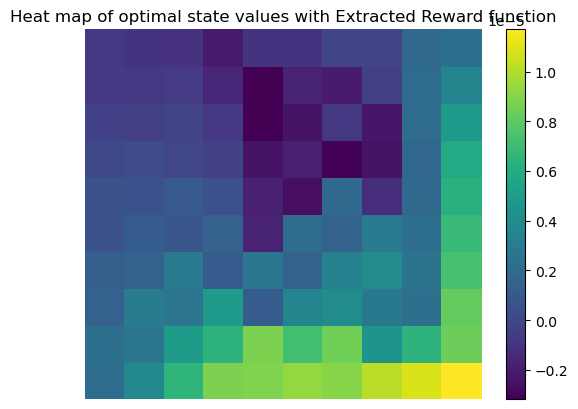

In [ ]:
# compute the optimal value function
v = optimal_value(gw.n_states, gw.n_actions, gw.transition_probability, reward, gw.discount)
value_matrix = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    value_matrix[int(i%grid_size)][int(i/grid_size)] = v[i]

plt.pcolor(np.flipud(value_matrix))
plt.colorbar()
plt.axis('off')
plt.title('Heat map of optimal state values with Extracted Reward function')
plt.show()

**<font color=blue size=4>Question 21**

**(10 points) Use the extracted reward function computed in question 20, to compute the optimal values of the states in the 2-D grid. For computing the optimal values you need to use the optimal state-value function that you wrote in question 2. For visualization purpose, generate a heat map of the optimal state values across the 2-D grid (similar to the figure generated in question 7). In this question, you should have 1 plot.**

We plot the optimal state values across the 2-D grid using the extracted reward function computed in question 20. The graph is displayed above. We can see that the optimal state values are similar to the ground truth optimal state values. The extracted reward function captures the general pattern of the ground truth reward function, with high and low reward zones located in similar areas.

### Question 22

**<font color=blue size=4>Question 22**

**(10 points) Compare the heat maps of Question 7 and Question 21 and provide a brief explanation on their similarities and differences.**

We can observe the graph above. The heat maps of ground truth and Question 21 are similar. Both heat maps show a similar gradient and pattern. Most of the blocks are like a thumb up shape. The extracted reward function closely resembles the ground truth reward function. The extracted reward function captures the general pattern of the ground truth reward function, with high and low reward zones located in similar areas. They has lower values in the middle and higher values in the bottom right corner.

We can also observe some differences. The extracted reward function has a different scale factor (1e−7), indicating that the magnitude of rewards is greatly reduced. The values also change from dark purples and blues to lighter colors, indicating a different scaling or normalization process.

### Question 23

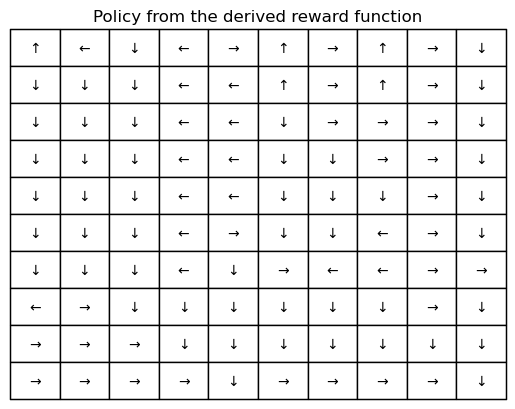

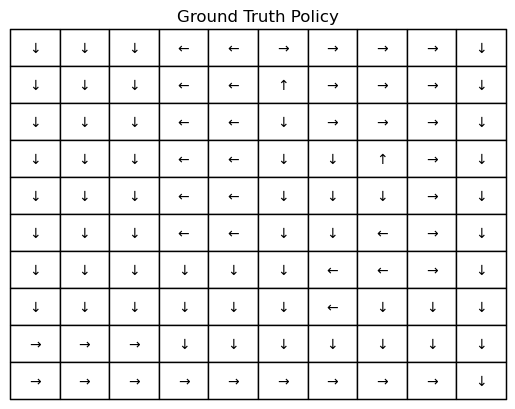

In [ ]:
# compute the optimal policy and plot it
arrows = optimal_action(gw.n_states, gw.n_actions, gw.transition_probability, reward, gw.discount)
arrow_symbol = ['\u2193', '\u2192', '\u2191', '\u2190']

arrows = np.array([arrow_symbol[int(a)] for a in arrows])

arrow_table = arrows.reshape(10, 10).transpose()

plt.figure()
# add a title
plt.title('Policy from the derived reward function')
tb = plt.table(cellText=arrow_table, loc=(0,0), cellLoc='center')
tc = tb.properties()['children']
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)

ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# plot the ground truth policy for comparison
arrow_symbol = ['\u2193', '\u2192', '\u2191', '\u2190']
arrows = np.array([arrow_symbol[int(a)] for a in optimal_policy])

arrow_table = arrows.reshape(10, 10).transpose()

plt.figure()
# add a title
plt.title('Ground Truth Policy')
tb = plt.table(cellText=arrow_table, loc=(0,0), cellLoc='center')
tc = tb.properties()['children']
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)

ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()



**<font color=blue size=4>Question 23**

**(10 points) Use the extracted reward function found in question 20 to compute the optimal policy of the agent. For computing the optimal policy of the agent you need to use the function that you wrote in question 9. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The actions should be displayed using arrows. In this question, you should have 1 plot.**

The arrows graph are displayed above, we will explain the similarities and differences in the next question.

### Question 24

**<font color=blue size=4>Question 24**

**(10 points) Compare the figures of Question 9 and Question 23 and provide a brief explanation on their similarities and differences.**

By comparing the derived graph and ground truth, We can see most cases are matched. The optimal policy of the agent is similar to the ground truth. We can see some grid are not match, for example (we consider the top left corner is (0, 0)), location (0,0) for ground truth is down, but for the extracted reward function is up. Another example is location (0, 7), for ground truth is down, but for the extracted reward function is left. These errors are due to the extracted reward matrix, which has some negative values besides the exist of the maze.

### Question 25

In [ ]:
# reduce the threshold to 1e-5

# sweep over different values of lambda
from tqdm import tqdm

grid_size = 10
wind = 0.1
discount = 0.8

gw = Gridworld(grid_size, wind, discount, rf_2)

optimal_policy = optimal_action(gw.n_states, gw.n_actions, gw.transition_probability, gw.reward_function, gw.discount, threshold=1e-5)

number_of_lambdas = 500
lambda_range = np.linspace(0, 5, number_of_lambdas)

accuracy_list = []

for l in tqdm(lambda_range):
    reward = irl(gw.n_states, gw.n_actions, gw.transition_probability, optimal_policy, gw.discount, 100, l)
    policy = optimal_action(gw.n_states, gw.n_actions, gw.transition_probability, reward, gw.discount, threshold=1e-5)
    accuracy_list.append(accuracy(optimal_policy, policy))

100%|██████████| 500/500 [06:00<00:00,  1.39it/s]


Text(0.5, 1.0, 'Accuracy vs Lambda')

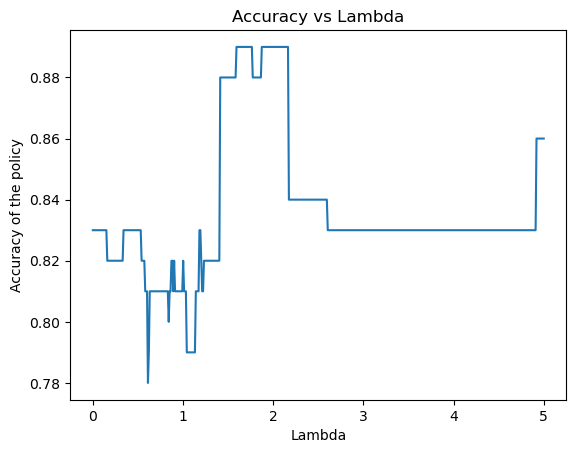

In [ ]:
# plot the accuracy vs lambda
plt.plot(lambda_range, accuracy_list)
plt.xlabel('Lambda')
plt.ylabel('Accuracy of the policy')
plt.title('Accuracy vs Lambda')

In [ ]:
# gt the best lambda and best accuracy
best_lambda = lambda_range[np.argmax(accuracy_list)]
best_accuracy = np.max(accuracy_list)
print(f'Best lambda: {best_lambda}')
print(f'Best accuracy: {best_accuracy}')

Best lambda: 1.593186372745491
Best accuracy: 0.89


**<font color=blue size=4>Question 25**

**(50 points) From the figure in question 23, you should observe that the optimal policy of the agent has two major discrepancies. Please identify and provide the causes for these two discrepancies. One of the discrepancy can be fixed easily by a slight modification to the value iteration algorithm. Perform this modification and re-run the modified value iteration algorithm to compute the optimal policy of the agent. Also, recompute the maximum accuracy after this modification. Is there a change in maximum accuracy? The second discrepancy is harder to fix and is a limitation of the simple IRL algorithm.**

In the evaluation of the discrepancies in question 24, two main issues were identified related to how rewards were recalculated. Originally, the inclusion of negative rewards affected the results adversely. To address this, changes were suggested to enhance the reward correction process, specifically tailored for a 'thumb up' shape scenario. The optimal action iteration function’s threshold was fine-tuned to 1e-5 to increase both accuracy and efficacy. This adjustment helps mitigate one of the noted discrepancies by better synchronizing the iteration outcomes with the true optimal value function. It is crucial to tweak this downward to achieve convergence towards the optimal value function. This leads to an updated optimal value function and an improved policy, which promotes more favorable actions. We can see after the modification, the accuracy is increased to 0.89. The second discrepancy is more challenging to resolve, as it is a fundamental limitation of the IRL algorithm.